# Figure to show the content of all of GALAH DR3
### This Figure is used in Sect. 2 on Data to allow us to find reasonable chemical selections of accreted stars

#### Author(s):
Sven Buder

#### History:
210329: Created

In [1]:
# Preamble for notebook 

# Compatibility with Python 3
from __future__ import (absolute_import, division, print_function)

try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

# Basic packages
import warnings
warnings.filterwarnings("ignore")
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
from astropy.table import Table, join
from sklearn import mixture

# Matplotlib and associated packages for plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

params = {
    'font.family'        : 'serif',
    'text.usetex'        : True, 
    'text.latex.preamble': [r'\usepackage{upgreek}', r'\usepackage{amsmath}'],
    }   
plt.rcParams.update(params)

In [2]:
def get_and_join_data(directory = '../data/'):
    
    # Join all data
    galah_dr3_main = Table.read(directory+'GALAH_DR3_main_allspec_v2.fits')
    galah_dr3_dynamics = Table.read(directory+'GALAH_DR3_VAC_dynamics_v2.fits')
    galah_dr3_gaiaedr3 = Table.read(directory+'GALAH_DR3_VAC_GaiaEDR3_v2.fits')
    galah_dr3_ages = Table.read(directory+'GALAH_DR3_VAC_ages_v2.fits')
    galah_dr3_rv = Table.read(directory+'GALAH_DR3_VAC_rv_v2.fits')
    data_12 = join(galah_dr3_main, galah_dr3_dynamics, keys='sobject_id')
    data_123 = join(data_12, galah_dr3_gaiaedr3, keys='sobject_id')
    data_1234 = join(data_123, galah_dr3_ages, keys='sobject_id')
    data = join(data_1234, galah_dr3_rv, keys='sobject_id')
    
    # get best rv and e_rv
    data['best_rv'] = np.zeros(len(data['sobject_id'])); data['best_rv'][:] = np.nan;
    data['best_rv'][data['use_rv_flag_1']==0] = data['rv_obst'][data['use_rv_flag_1']==0]
    data['best_rv'][data['use_rv_flag_1']==1] = data['rv_sme_v2'][data['use_rv_flag_1']==1]
    data['best_rv'][data['use_rv_flag_1']==2] = data['dr2_radial_velocity_1'][data['use_rv_flag_1']==2]

    data['best_e_rv'] = np.zeros(len(data['sobject_id'])); data['best_e_rv'][:] = np.nan;
    data['best_e_rv'][data['use_rv_flag_1']==0] = data['e_rv_obst'][data['use_rv_flag_1']==0]
    data['best_e_rv'][data['use_rv_flag_1']==1] = data['e_rv_sme'][data['use_rv_flag_1']==1]
    data['best_e_rv'][data['use_rv_flag_1']==2] = data['dr2_radial_velocity_error_1'][data['use_rv_flag_1']==2]
    
    # get best distance and 16th + 84th percentile
    data['best_d'] = np.zeros(len(data['sobject_id'])); data['best_d'][:] = np.nan;
    data['best_d_16'] = np.zeros(len(data['sobject_id'])); data['best_d_16'][:] = np.nan;
    data['best_d_50'] = np.zeros(len(data['sobject_id'])); data['best_d_50'][:] = np.nan;
    data['best_d_84'] = np.zeros(len(data['sobject_id'])); data['best_d_84'][:] = np.nan;

    data['best_d'][data['use_dist_flag']==0] = 1000.*data['distance_bstep'][data['use_dist_flag']==0]
    data['best_d_16'][data['use_dist_flag']==0] = 1000.*data['e16_distance_bstep'][data['use_dist_flag']==0]
    data['best_d_50'][data['use_dist_flag']==0] = 1000.*data['e50_distance_bstep'][data['use_dist_flag']==0]
    data['best_d_84'][data['use_dist_flag']==0] = 1000.*data['e84_distance_bstep'][data['use_dist_flag']==0]

    data['best_d'][data['use_dist_flag']==1] = data['r_med_photogeo'][data['use_dist_flag']==1]
    data['best_d_16'][data['use_dist_flag']==1] = data['r_lo_photogeo'][data['use_dist_flag']==1]
    data['best_d_50'][data['use_dist_flag']==1] = data['r_med_photogeo'][data['use_dist_flag']==1]
    data['best_d_84'][data['use_dist_flag']==1] = data['r_hi_photogeo'][data['use_dist_flag']==1]

    data['best_d'][data['use_dist_flag']==2] = data['r_med_geo'][data['use_dist_flag']==2]
    data['best_d_16'][data['use_dist_flag']==2] = data['r_lo_geo'][data['use_dist_flag']==2]
    data['best_d_50'][data['use_dist_flag']==2] = data['r_med_geo'][data['use_dist_flag']==2]
    data['best_d_84'][data['use_dist_flag']==2] = data['r_hi_geo'][data['use_dist_flag']==2]

    data['best_d'][data['use_dist_flag']==4] = 1000./data['parallax_corr'][data['use_dist_flag']==4]
    data['best_d_16'][data['use_dist_flag']==4] = 1000./(data['parallax_corr'][data['use_dist_flag']==4]+data['parallax_error'][data['use_dist_flag']==4])
    data['best_d_50'][data['use_dist_flag']==4] = 1000./(data['parallax_corr'][data['use_dist_flag']==4]-data['parallax_error'][data['use_dist_flag']==4])
    data['best_d_84'][data['use_dist_flag']==4] = 1000./data['r_hi_geo'][data['use_dist_flag']==4]

    data['theta_spherical'] = np.arctan2(data['R_Rzphi'], data['z_Rzphi'])
    data['rho_spherical'] = np.sqrt((data['R_Rzphi'])**2+(data['z_Rzphi'])**2)
    data['vrho_spherical'] = (data['R_Rzphi']*data['vR_Rzphi'] + data['z_Rzphi']*data['vz_Rzphi'])/data['rho_spherical']
    data['vtheta_spherical'] = (data['z_Rzphi']*data['vR_Rzphi'] - data['R_Rzphi']*data['vz_Rzphi'])/data['rho_spherical']

    return data

# test if joined data file already exists
try:
    data = Table.read('../../data/GALAH_DR3_all_joined_v2.fits')
except:
    data = get_and_join_data(directory = '../../data/')
    data.write('../../data/GALAH_DR3_all_joined_v2.fits')

In [3]:
# Selection basics

basic_cuts = (
    (data['flag_sp'] == 0) &
    (data['best_d'] <= 10000.) &
    np.isfinite(data['L_Z']) &
    np.isfinite(data['ecc']) &
    np.isfinite(data['age_bstep'])
)

basic_cuts_mgalpha = (
    basic_cuts &
    (data['flag_alpha_fe'] == 0) &
    (data['flag_Mg_fe'] == 0)
)

def nissen_slope_mg_fe(fe_h):
    """
    Slope [Fe/H] vs. [Mg/Fe] as estimated from 2010A%26A...511L..10N
    
    -1/12 * [Fe/H] + 1/6
    
    """
    return -0.1/1.2*(fe_h)+(0.3 - 1.6*0.1/1.2)

def nissen_slope_alpha_fe(fe_h):
    """
    Slope [Fe/H] vs. [alpha/Fe] as estimated from 2010A%26A...511L..10N
    
    -0.2/1.2*(fe_h)+(0.325 - 1.6*0.2/1.2)
    
    -1/6 * [Fe/H] + 0.7/12
    
    """
    return -0.2/1.2*(fe_h)+(0.325 - 1.6*0.2/1.2)

def total_velocity(data):
    """
    return the total space velocity:
    
    sqrt(pow(rv_galah,2) + (pow(4.7623*r_est/1000.,2)*(pow(pmra,2) + pow(pmdec,2))))
    
    """
    return np.sqrt(
            (data['best_rv'])**2 + 
            (4.7623*data['best_d']/1000.)**2 * 
            ((data['pmra'])**2 + (data['pmdec'])**2)
        )

def tangential_velocity(data):
    return (4.7623*data['best_d']/1000.)*np.sqrt((data['pmra'])**2 + (data['pmdec'])**2)

rgb = (
    (data['teff'] < 5500) &
    (data['logg'] < 3.25)
)

msto = (
    (data['teff'] >= 5350) &
    (data['logg'] >= 3.5)
)

stars_with_high_vtot = (
    basic_cuts & 
    (total_velocity(data) > 180)
)

stars_with_high_vtan = (
    basic_cuts & 
    (tangential_velocity(data) > 180)
)

preliminary_low_alpha_halo = (
    basic_cuts_mgalpha &
    (total_velocity(data) > 180) &
    (data['fe_h'] >= -2.0) & (data['fe_h'] <= -0.4) &
    (data['Mg_fe'] < nissen_slope_mg_fe(data['fe_h']))&
    (data['alpha_fe'] < nissen_slope_alpha_fe(data['fe_h']))
)

# Selection via [Mg/Cu] vs. [Na/Fe]
chem1 = (
    basic_cuts &
    (data['flag_Mg_fe'] == 0) &
    (data['flag_Na_fe'] == 0) &
    (data['flag_Cu_fe'] == 0) &
    (data['Mg_fe'] - data['Cu_fe'] > 0.5) &
    (data['Na_fe'] < -0.1)
)

# Selection via [Mg/Mn] vs. [Na/Fe] + [Fe/H]
chem2 = (
    basic_cuts &
    (data['flag_Mg_fe'] == 0) &
    (data['flag_Mn_fe'] == 0) &
    (data['flag_Na_fe'] == 0) &
    (np.abs(data['Mg_fe'] - data['Mn_fe'] - 0.5) <= 0.25) &
    (data['Na_fe'] < -0.1) &
    (data['fe_h'] <= -0.8)
)

# Selection via L_Z and J_R like Feuillet+2020
feuillet2020 = (
    basic_cuts &
    (data['L_Z'] >= -500) &
    (data['L_Z'] <= 500) &
    (data['J_R'] >= 30**2) &
    (data['J_R'] <= 50**2)
)

In [4]:
def plot_feh_mgfe(data,ax,sample_name,name_location='Title',panel='a)',cmap='Greys',logscale=True,cmap_up=False):
    if logscale:
        p,x,y,s = ax.hist2d(
            data['fe_h'],
            data['Mg_fe'],
            bins=(np.linspace(-2.0,0.75,150),np.linspace(-0.75,1.00,150)),cmin=1,
            cmap=cmap,norm=LogNorm()
        )
    else:
        p,x,y,s = ax.hist2d(
            data['fe_h'],
            data['Mg_fe'],
            bins=(np.linspace(-2.0,0.75,150),np.linspace(-0.75,1.00,150)),cmin=1,
            cmap=cmap
        )
    ax.set_xlabel(r'[Fe/H]')
    ax.set_ylabel(r'[Mg/Fe]')
    if not cmap_up:
        c = plt.colorbar(s,ax=ax)
    else:
        c = plt.colorbar(s,ax=ax,orientation='horizontal')
    if name_location=='Title':
        ax.set_title(sample_name)
        c.set_label('Nr. Spectra')
    else:
        c.set_label('Nr. Spectra')
        # c.set_label('Nr. Spectra '+sample_name)
    ax.text(0.05,0.95,panel,transform=ax.transAxes,ha='left',va='top',bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))

In [5]:
def plot_nafe_mgcu(data,ax,sample_name,name_location='Title',panel='a)',cmap='Greys',logscale=True,cmap_up=False):
    if logscale:
        p,x,y,s = ax.hist2d(
            data['Na_fe'],
            data['Mg_fe']-data['Cu_fe'],
            bins=(np.linspace(-0.75,0.75,200),np.linspace(-0.75,1.25,150)),cmin=1,
            cmap=cmap,norm=LogNorm()
        )
    else:
        p,x,y,s = ax.hist2d(
            data['Na_fe'],
            data['Mg_fe']-data['Cu_fe'],
            bins=(np.linspace(-0.75,0.75,200),np.linspace(-0.75,1.25,150)),cmin=1,
            cmap=cmap
        )
    ax.set_xlabel(r'[Na/Fe]')
    ax.set_ylabel(r'[Mg/Cu]')
    if not cmap_up:
        c = plt.colorbar(s,ax=ax)
    else:
        c = plt.colorbar(s,ax=ax,orientation='horizontal')
    if name_location=='Title':
        ax.set_title(sample_name)
        c.set_label('Nr. Spectra')
    else:
        c.set_label('Nr. Spectra')
        #c.set_label('Nr. Spectra '+sample_name)
    ax.text(0.05,0.95,panel,transform=ax.transAxes,ha='left',va='top',bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))

In [6]:
def plot_lz_sqrtjr(data,ax,sample_name,name_location='Title',panel='a)',cmap='Greys',logscale=True,cmap_up=False):
    if logscale:
        p,x,y,s = ax.hist2d(
            data['L_Z'],
            np.sqrt(data['J_R']),
            bins=(np.linspace(-1000,3000,200),np.linspace(0,50,150)),cmin=1,
            cmap=cmap,norm=LogNorm()
        )
    else:
        p,x,y,s = ax.hist2d(
            data['L_Z'],
            np.sqrt(data['J_R']),
            bins=(np.linspace(-1000,3000,200),np.linspace(0,50,150)),cmin=1,
            cmap=cmap
        )
    ax.set_xlabel(r'$L_Z~/~\mathrm{kpc\,km\,s^{-1}}$')
    ax.set_ylabel(r'$\sqrt{J_R~/~\mathrm{kpc\,km\,s^{-1}}}$')
    if not cmap_up:
        c = plt.colorbar(s,ax=ax)
    else:
        c = plt.colorbar(s,ax=ax,orientation='horizontal')
    if name_location=='Title':
        ax.set_title(sample_name)
        c.set_label('Nr. Spectra')
    else:
        c.set_label('Nr. Spectra')
    ax.text(0.05,0.95,panel,transform=ax.transAxes,ha='left',va='top',bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))

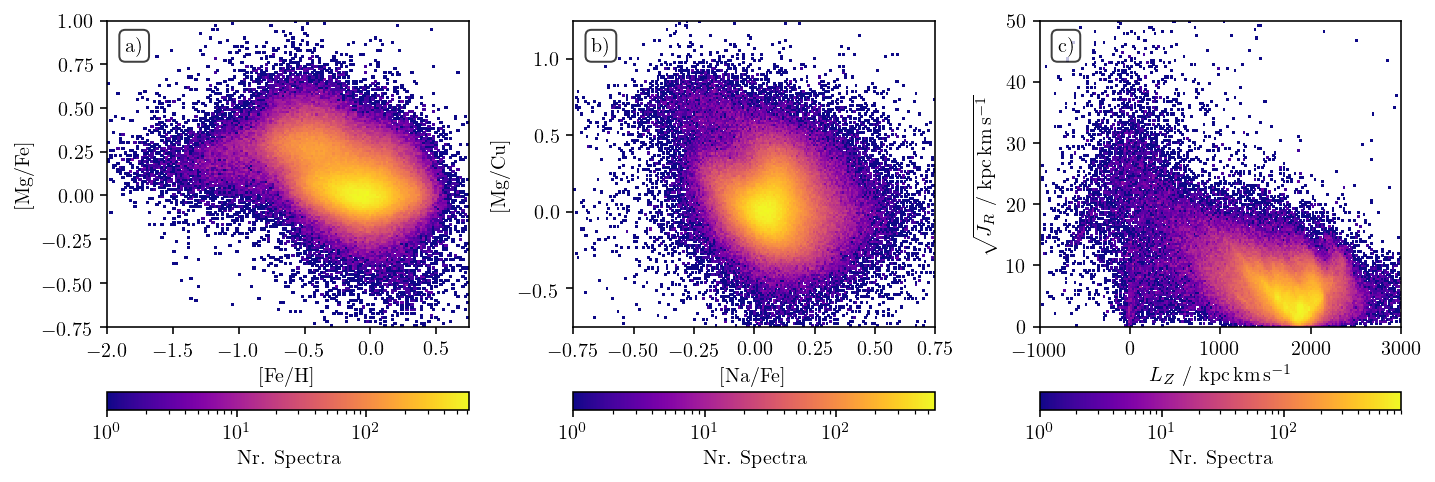

In [7]:
def plot_sample_overview(save=True):
    f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(10,3.5))
    
    plot_feh_mgfe(data[basic_cuts],ax=ax1,sample_name='Base sample',cmap='plasma',cmap_up=True,name_location='cmap',panel='a)')
    plot_nafe_mgcu(data[basic_cuts],ax=ax2,sample_name='Base sample',cmap='plasma',cmap_up=True,name_location='cmap',panel='b)')
    plot_lz_sqrtjr(data[basic_cuts],ax=ax3,sample_name='Base sample',cmap='plasma',cmap_up=True,name_location='cmap',panel='c)')
    plt.tight_layout()
    if save:
        plt.savefig('figure_data_overview.png',dpi=300,bbox_inches='tight')

plot_sample_overview()